In [1]:
#Load USPS Dataset
import h5py
path="usps.h5"
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = hf.get('test')
        X_test = test.get('data')[:]
        y_test = test.get('target')[:]

#Import libraries 
import numpy as np
import math 
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
import time
from sklearn.model_selection import train_test_split
%matplotlib inline

#Split data into training set proper, calibration set and test set
X_train_p, X_cal, y_train_p, y_cal = train_test_split(X_train, y_train, random_state=0)

print("Training Proper Size:", len(X_train_p))
print("Calibration Set Size:",len(X_cal))
print("Test Set Size:",len(X_test))



Training Proper Size: 5468
Calibration Set Size: 1823
Test Set Size: 2007


# SVM - Transductive Point Prediction Algorithm

In [24]:
 def svm_conf_predictor(X_train,y_train,X_test,y_test,kernel ):
    #Initialize variables for storage
    SVM=SVC(kernel=kernel)
    score=np.zeros(len(X_train)+1)
    p_values=np.zeros((len(X_test),len(set(y_train))))
    prediction=np.zeros(len(X_test))
    confidence=np.zeros(len(X_test))
    credibility=np.zeros(len(X_test))
    sum_p_values=0
    #Loop through test samples
    for i in range(len(X_test)):
        #Create new dataset which is the training set + the test sample
        extend_train_X=np.row_stack((X_train,X_test[i]))
        for j in set(y_train): #Test all possible labels
            #Extend labels with test sample
            extend_train_y=np.append(y_train,j)
            #Calculate conformity scores for each sample in the extended set
            SVM.fit(extend_train_X,extend_train_y)
            d_func=SVM.decision_function(extend_train_X)
            row=np.arange(0,len(d_func))
            score=-1*d_func[row,extend_train_y]
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(score>=score[-1])
        #Use p-values of test sample to calculate various measures
        prediction[i]=int(np.argmax(p_values[i]))
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]
        credibility[i]=np.max(p_values[i])
        sum_p_values = sum_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]
    false_p_value=sum_p_values/(2*len(X_test))
    return prediction, confidence, credibility, false_p_value

In [25]:
start_time = time.time()
svm_pred=svm_conf_predictor(X_train,y_train,X_test[0:2],y_test[0:2],"rbf" )
print("--- %s seconds ---" % (time.time() - start_time))

--- 167.60297203063965 seconds ---


In [ ]:
print("Linear SVM Accuracy: ", np.mean(svm_pred[0]==y_test))
print("Linear SVM Avg False p-value: ", svm_pred[3])
print("Linear Avg Credibility: ",np.mean(svm_pred[2]))

# SVM Inductive Point Prediction Algorithm

In [2]:
def svm_induc_conf_predictor(X_train_p,y_train_p,X_cal,y_cal,X_test,y_test,kernel, smooth ):
    #Initialize variables for storage
    p_values=np.zeros((len(X_test),len(set(y_train))))
    prediction=np.zeros(len(X_test))
    confidence=np.zeros(len(X_test))
    credibility=np.zeros(len(X_test))
    sum_p_values=0
    SVM=SVC(kernel=kernel)
    SVM.fit(X_train_p,y_train_p)
    #Calculate non-conformity scores for the calibration set
    d_func_cal=SVM.decision_function(X_cal)
    row=np.arange(0,len(d_func_cal))
    score=-1*d_func_cal[row,y_cal]
    #Calculate non-conformity scores for the test set
    d_func_test=SVM.decision_function(X_test)
    #Loop through test samples
    for i in range(len(X_test)):
        for j in set(y_train_p): #Test all possible labels
            score_extend=np.append(score,(-1*d_func_test[i][j]))
            #Calculate p-values of test sample
            if smooth == True:
                tau=np.random.uniform()
                p_values[i][j]=(np.sum(score_extend>score_extend[-1])+(tau*(np.sum(score_extend==score_extend[-1]))))/len(score_extend)
            else:
                p_values[i][j]=np.mean(score_extend>=score_extend[-1])
        #Use p-values of test sample to calculate various measures
        prediction[i]=int(np.argmax(p_values[i]))
        confidence[i]=1- p_values[i][np.argsort(p_values[i])[-2]]
        credibility[i]=np.max(p_values[i])
        sum_p_values = sum_p_values + np.sum(p_values[i]) - p_values[i][y_test[i]]
    false_p_value=sum_p_values/(2*len(X_test))
    return prediction, confidence, credibility, p_values, false_p_value

In [3]:
start_time = time.time()
svm_induc_pred=svm_induc_conf_predictor(X_train_p,y_train_p,X_cal,y_cal,X_test,y_test,"rbf" ,False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.98491644859314 seconds ---


In [4]:
print("Inductive SVM Accuracy: ", np.mean(svm_induc_pred[0]==y_test))
print("Inductive SVM Avg False p-value: ", svm_induc_pred[4])
print("Inductive Avg Credibility: ",np.mean(svm_induc_pred[2]))
print("Inductive Avg Confidence: ",np.mean(svm_induc_pred[1]))

Inductive SVM Accuracy:  0.9456900847035377
Inductive SVM Avg False p-value:  0.019194059825697826
Inductive Avg Credibility:  0.47426933364802143
Inductive Avg Confidence:  0.9840219320098952


# SVM Inductive Prediction Set Algorithm

In [35]:
def svm_induc_conf_prediction_set(X_train_p,y_train_p,X_cal,y_cal,X_test,y_test, kernel, sig):
    #Initialize variables for storage
    p_values=np.zeros((len(X_test),len(set(y_train))))
    prediction_set=[0] * len(X_test)
    SVM=SVC(kernel=kernel)
    SVM.fit(X_train_p,y_train_p)
    d_func_cal=SVM.decision_function(X_cal)
    row=np.arange(0,len(d_func_cal))
    score=-1*d_func_cal[row,y_cal]
    d_func_test=SVM.decision_function(X_test)
    #Loop through test samples
    for i in range(len(X_test)):
        for j in set(y_train_p): #Test all possible labels
            score_extend=np.append(score,(-1*d_func_test[i][j]))
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(score_extend>=score_extend[-1])
        #Use p-values of test sample to calculate various measures
        prediction_set[i]=list(np.where(p_values[i]>(sig))[0])
    return prediction_set, p_values

# SVM Inductive Validity Curve

In [6]:
error_rate=[]
sigs=[0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for sig in sigs :
    prediction_set=[0] * len(X_test)
    error=0
    for i in range(len(X_test)):
        prediction_set[i]=list(np.where(svm_induc_pred[3][i]>(sig))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate=np.append(error_rate,error/len(X_test))

Text(0.5, 1.0, 'Inductive SVM Validity Curve')

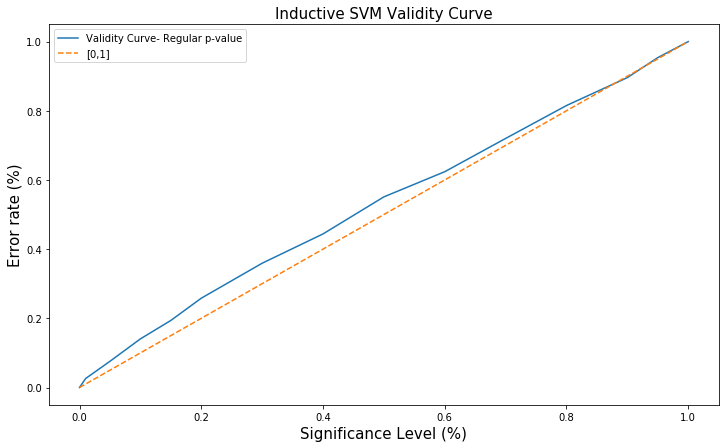

In [7]:
plt.figure(figsize=(12,7))
plt.plot(sigs,error_rate)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validity Curve- Regular p-value","[0,1]"])
plt.xlabel("Significance Level (%)",fontsize=15)
plt.ylabel("Error rate (%)",fontsize=15)
plt.title("Inductive SVM Validity Curve",fontsize=15)

# SVM Inductive Smoothed P-value

In [4]:
start_time = time.time()
svm_induc_pred_smooth=svm_induc_conf_predictor(X_train_p,y_train_p,X_cal,y_cal,X_test,y_test,"rbf" ,True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.42676043510437 seconds ---


In [5]:
error_rate_smooth=[]
sigs=[0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for sig in sigs :
    prediction_set=[0] * len(X_test)
    error=0
    for i in range(len(X_test)):
        prediction_set[i]=list(np.where(svm_induc_pred_smooth[3][i]>(sig))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate_smooth=np.append(error_rate_smooth,error/len(X_test))

Text(0.5, 1.0, 'Inductive SVM Validity Curve')

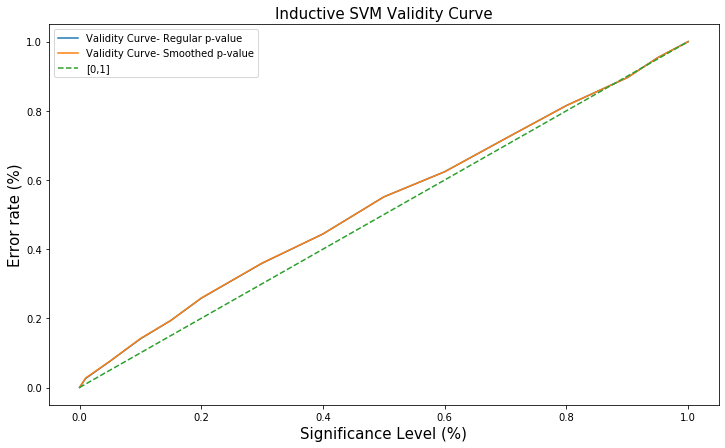

In [8]:
plt.figure(figsize=(12,7))
plt.plot(sigs,error_rate)
plt.plot(sigs,error_rate_smooth)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validity Curve- Regular p-value","Validity Curve- Smoothed p-value","[0,1]"])
plt.xlabel("Significance Level (%)",fontsize=15)
plt.ylabel("Error rate (%)",fontsize=15)
plt.title("Inductive SVM Validity Curve",fontsize=15)